In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


### Import necessary libraries

In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

### Error Level Analysis

In [3]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [4]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [5]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [6]:
import os

# Define paths to CASIA1 and CASIA2 datasets
class Config:
    CASIA1 = r"C:\Users\Hiral Patel\Desktop\dataset\CASIA1"
    CASIA2 = r"C:\Users\Hiral Patel\Desktop\dataset\CASIA2"

In [13]:
pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------- -------------------------- 0.8/2.3 MB 4.8 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
pip install numpy==1.22.0 pandas==1.4 scipy==1.11.2 pydantic==1.10.2

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Using cached numpy-1.22.0-cp310-cp310-win_amd64.whl (14.7 MB)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/10.6 MB 4.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/10.6 MB 4.2 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.6 MB 4.3 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/10.6 MB 4.4 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/10.6 MB 4.3 MB/s eta 0:00:02
   ------------------- -------------------- 5.2/10.6 MB 4.2 MB/s eta 0:00:02
   ---------------------- ----------------- 6.0/10.6 MB 4.1 MB/s eta 0:00:02
   ------------------------- -------------- 6.8/10.6 MB 4.1 MB/s eta 0:00:01
   ----------------------------- ---------- 7.9/10.6 MB 4.1 MB/s eta 0:00:01
   ----------------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chromadb 0.5.4 requires numpy<2.0.0,>=1.22.5, but you have numpy 1.22.0 which is incompatible.
gruut 2.2.3 requires networkx<3.0.0,>=2.5.0, but you have networkx 3.0 which is incompatible.
mediapipe 0.10.11 requires protobuf<4,>=3.11, but you have protobuf 4.24.4 which is incompatible.
spacy 3.5.2 requires typer<0.8.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
ultralytics 8.0.200 requires numpy>=1.22.2, but you have numpy 1.22.0 which is incompatible.
albucore 0.0.20 requires numpy>=1.24.4, but you have numpy 1.22.0 which is inco

In [14]:
pip install tqdm --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tts 0.22.0 requires numpy==1.22.0; python_version <= "3.10", but you have numpy 1.24.4 which is incompatible.
tts 0.22.0 requires pandas<2.0,>=1.4, but you have pandas 2.0.3 which is incompatible.
tts 0.22.0 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
spacy 3.5.2 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.9.2 which is incompatible.
spacy 3.5.2 requires typer<0.8.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.

[notice] A new release of pip is available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
#adding authentic images

path = os.path.join(Config.CASIA2, 'Au/')       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [8]:
#adding forged images

path = os.path.join(Config.CASIA2, 'Tp/')       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5124 [00:00<?, ?it/s]

Total images: 9418
Total labels: 9418


In [9]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

### Partitioning dataset for training, validation and testing

In [10]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 7157 , Training labels: 7157
Validation images: 1790 , Validation labels: 1790
Test images: 471 , Test labels: 471


### CNN Model

In [11]:
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                   

### Model Training

In [13]:
epochs = 15
batch_size = 32


In [16]:
pip install --use-deprecated=legacy-resolver

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: You must give at least one requirement to install (see "pip help install")


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Initialize learning rate and decay parameters
init_lr = 1e-4
epochs = 50

# Learning rate decay using ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=init_lr,
    decay_steps=epochs,
    decay_rate=0.96,  # You can adjust this value
    staircase=True)

# Create the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [22]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/50
224/224 [==============================] - 2068s 9s/step - loss: 0.3718 - accuracy: 0.8005 - val_loss: 0.2817 - val_accuracy: 0.8581
Epoch 2/50
224/224 [==============================] - 1780s 8s/step - loss: 0.2731 - accuracy: 0.8747 - val_loss: 0.2572 - val_accuracy: 0.8760
Epoch 3/50
224/224 [==============================] - 1839s 8s/step - loss: 0.2602 - accuracy: 0.8794 - val_loss: 0.2438 - val_accuracy: 0.8849
Epoch 4/50
224/224 [==============================] - 1814s 8s/step - loss: 0.2449 - accuracy: 0.8920 - val_loss: 0.2158 - val_accuracy: 0.9101
Epoch 5/50
216/224 [===========================>..] - ETA: 1:12 - loss: 0.2307 - accuracy: 0.9028

KeyboardInterrupt: 

In [ ]:
#save the model as a h5 file
model.save('.h5') 

# get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history

# save it as a json file
json.dump(history_dict, open('', 'w'))

### Plotting the training and validation curves

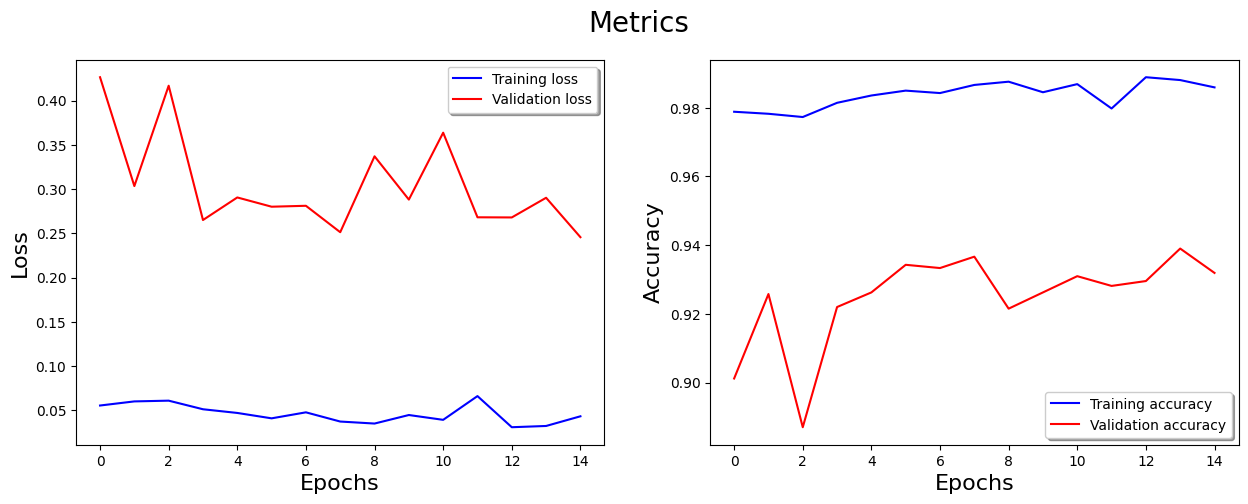

In [24]:
import json
import matplotlib.pyplot as plt

# Load the model history data from the JSON file
with open('model_history.json', 'r') as f:
    history_dict = json.load(f)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Figure 1: Loss plot
ax[0].plot(history_dict['loss'], color='b', label="Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label="Validation loss")
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Loss', fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

# Figure 2: Accuracy plot
ax[1].plot(history_dict['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

# Set the overall title for the figure
fig.suptitle('Metrics', fontsize=20)

# Show the plot
plt.show()

### Confusion Matrix

In [28]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

56/56 [==============================] - 82s 1s/step


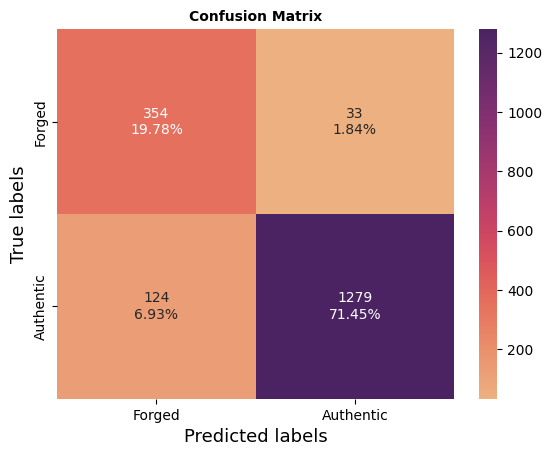

In [29]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


### Classification Report

In [30]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       387
           1       0.97      0.91      0.94      1403

    accuracy                           0.91      1790
   macro avg       0.86      0.91      0.88      1790
weighted avg       0.92      0.91      0.92      1790



### Testing Accuracy

In [31]:
class_names = ['Forged', 'Authentic']

In [32]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

Processing Images :   0%|          | 0/471 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step
Total test images: 471
Correctly predicted images: 435
Accuracy: 92.35668789808918 %


# Test an image

In [ ]:
test_image_path = ''    # test image path
test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

# Test a dataset

In [ ]:
test_folder_path = ''        #dataset path
authentic,forged,total = 0,0,0

for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(path, filename)
        test_image = prepare_image(test_image_path)  
        test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.round(y_pred)
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic +=1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')